We will try to improve our score by implementing few simple changes to the initial baseline

In [1]:
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
df = pd.read_csv("input/train_electricity.csv")
df_test = pd.read_csv("input/test_electricity.csv")

print("Dataset has", len(df), "entries.")

print(f"\n\t{'Column':20s} | {'Type':8s} | {'Min':12s} | {'Max':12s}\n")
for col_name in df.columns:
    col = df[col_name]
    print(f"\t{col_name:20s} | {str(col.dtype):8s} | {col.min():12.1f} | {col.max():12.1f}")

Dataset has 419403 entries.

	Column               | Type     | Min          | Max         

	Date                 | int64    | 1262487660.0 | 1514947775.0
	Consumption_MW       | float64  |         44.0 |      26209.0
	Coal_MW              | float64  |       -485.0 |       5702.0
	Gas_MW               | float64  |       -414.0 |       2666.0
	Hidroelectric_MW     | float64  |          0.0 |       4728.0
	Nuclear_MW           | float64  |          0.0 |       1450.0
	Wind_MW              | float64  |       -521.0 |       7944.0
	Solar_MW             | float64  |         -6.0 |        859.0
	Biomass_MW           | float64  |          0.0 |        110.0
	Production_MW        | float64  |          0.0 |      11295.0


In [3]:
df.head()

,Date,Consumption_MW,Coal_MW,Gas_MW,Hidroelectric_MW,Nuclear_MW,Wind_MW,Solar_MW,Biomass_MW,Production_MW
0,1262487660,5302.0,1754.0,1144.0,1391.0,706.0,0.0,0.0,0.0,4995.0
1,1262488200,5318.0,1777.0,1145.0,1468.0,708.0,0.0,0.0,0.0,5097.0
2,1262488800,5268.0,1743.0,1139.0,1361.0,708.0,0.0,0.0,0.0,4951.0
3,1262489400,5358.0,1759.0,1142.0,1449.0,707.0,0.0,0.0,0.0,5057.0
4,1262490060,5327.0,1764.0,1142.0,1417.0,709.0,0.0,0.0,0.0,5031.0


## Datetime features
The first change is in datetime features.

Features "Is_year_end", "Is_year_start", "Is_month_end", "Is_month_start" don't present any new information and thus are removed. The same information is already contained in "Month" and "Day" categories.

### Say no to one-hot
Also, for tree-based models it is likely to be harmful to one-hot encode categorical features that has some order (like Month or Dayofweek in our case), so we're not gonna use one-hot. Why? Think about how a tree is built, in particular how a node splits. We'll look into two examples: one where one-hot-encoded version is better, and one when categorical version is better. For ordered data the second example usually outweights the first one (especially when the depth is limited).

Example 1: exactly month == 7 versus month != 7 gives the best improvement. In one-hot case this takes one split, i.e. month_7 >= 0.5 versus month_7 < 0.5 (month_7 is binary). In the categorical case, however, this takes at least two splits! First split is month >= 7 versus month < 7, and the second split is month <= 7 versus month > 7. This is because the split month == 7 versus month != 7 cannot exist, only > and < can be used. So, one-hot is better? No.

Example 2: month >= 7 versus month < 7 gives the best improvement. In categorical case this can be done with one split. However, in one-hot case it takes 6 splits to isolate all the months >= 7!

If the data is unordered, it might be that example 1 is a more likely scenario than example 2. That is not our case, and the negative effect of one-hot is scenario 2 is more devastating than negative effect of categorical in example 1. So no one-hot. (feel free to check effect on model performance)

### Year extrapolation
Also. About 'Year'. The test set consists of 2018 data, which the model has never seen, since the train set is up to 2017. This means that the model has to extrapolate. Linear models or neural networks would be able to do that. Trees, however, would not be able to detect trends, and would probably treat 2018 data as 2017. For tree-based models this yearly trend may be calculated manually to post-adjust xgboost predictions (i.e. multiplied by trend per day times day number). This is not implemented in this notebook, but feel free to try.

In [4]:
## 2. Adding some datetime related features

def add_datetime_features(df):
    features = ["Year", "Month", "Week", "Day", "Dayofyear", "Dayofweek",
                "Hour", "Minute"]#, "Is_year_end", "Is_year_start", "Is_month_end", "Is_month_start"]
    one_hot_features = []#["Month", "Dayofweek"]

    datetime = pd.to_datetime(df.Date * (10 ** 9))

    df['Datetime'] = datetime  # We won't use this for training, but we'll remove it later

    for feature in features:
        new_column = getattr(datetime.dt, feature.lower())
        if feature in one_hot_features:
            df = pd.concat([df, pd.get_dummies(new_column, prefix=feature)], axis=1)
        df[feature] = new_column
    return df

df = add_datetime_features(df)
df_test = add_datetime_features(df_test)
df.columns

Index(['Date', 'Consumption_MW', 'Coal_MW', 'Gas_MW', 'Hidroelectric_MW',
       'Nuclear_MW', 'Wind_MW', 'Solar_MW', 'Biomass_MW', 'Production_MW',
       'Datetime', 'Year', 'Month', 'Week', 'Day', 'Dayofyear', 'Dayofweek',
       'Hour', 'Minute'],
      dtype='object')

In [5]:
df.head()

,Date,Consumption_MW,Coal_MW,Gas_MW,Hidroelectric_MW,Nuclear_MW,Wind_MW,Solar_MW,Biomass_MW,Production_MW,Datetime,Year,Month,Week,Day,Dayofyear,Dayofweek,Hour,Minute
0,1262487660,5302.0,1754.0,1144.0,1391.0,706.0,0.0,0.0,0.0,4995.0,2010-01-03 03:01:00,2010,1,53,3,3,6,3,1
1,1262488200,5318.0,1777.0,1145.0,1468.0,708.0,0.0,0.0,0.0,5097.0,2010-01-03 03:10:00,2010,1,53,3,3,6,3,10
2,1262488800,5268.0,1743.0,1139.0,1361.0,708.0,0.0,0.0,0.0,4951.0,2010-01-03 03:20:00,2010,1,53,3,3,6,3,20
3,1262489400,5358.0,1759.0,1142.0,1449.0,707.0,0.0,0.0,0.0,5057.0,2010-01-03 03:30:00,2010,1,53,3,3,6,3,30
4,1262490060,5327.0,1764.0,1142.0,1417.0,709.0,0.0,0.0,0.0,5031.0,2010-01-03 03:41:00,2010,1,53,3,3,6,3,41


Let's look at our target

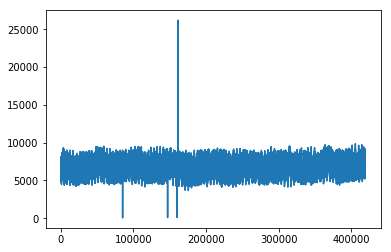

In [6]:
plt.plot(df['Consumption_MW'])

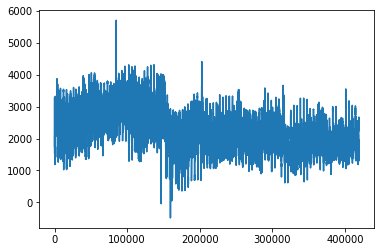

In [7]:
plt.plot(df['Coal_MW'])

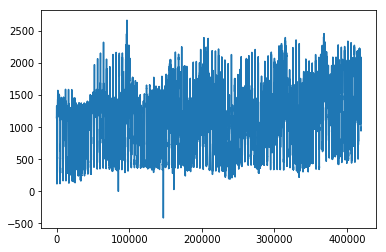

In [8]:
plt.plot(df['Gas_MW'])

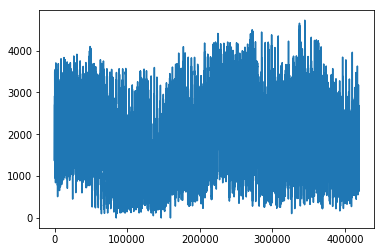

In [9]:
plt.plot(df['Hidroelectric_MW'])

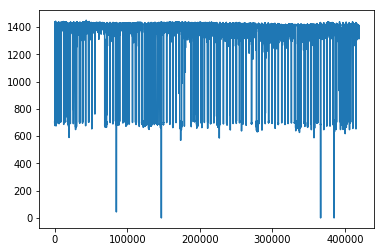

In [10]:
plt.plot(df['Nuclear_MW'])

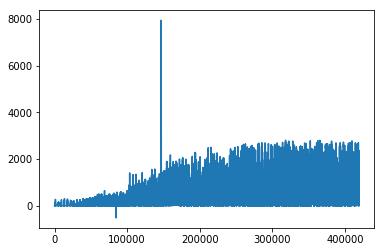

In [11]:
plt.plot(df['Wind_MW'])

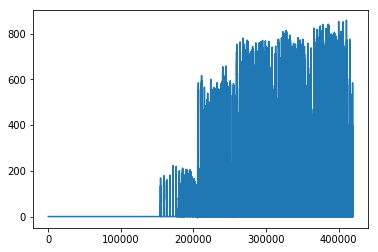

In [12]:
plt.plot(df['Solar_MW'])

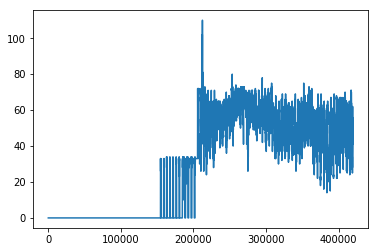

In [13]:
plt.plot(df['Biomass_MW'])

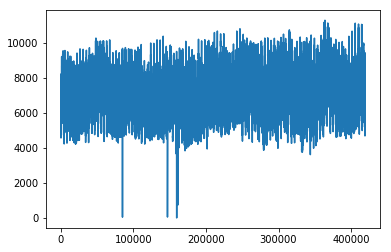

In [14]:
plt.plot(df['Production_MW'])

There are several outliers, feel free to try to correct them or exclude them from training set

### Deleting outliers that are 3 standard deviation away from the mean

In [15]:
df = df[(np.abs(stats.zscore(df[['Consumption_MW', 'Coal_MW', 'Gas_MW', 'Hidroelectric_MW', 'Nuclear_MW', 'Biomass_MW', 'Production_MW']])) < 3).all(axis=1)]

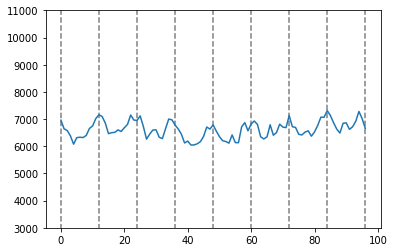

In [16]:
plt.plot(df.groupby(['Year', 'Month'])['Consumption_MW'].median().reset_index(drop=True))
plt.ylim(3000, 11000)
for l in range(9):
    plt.vlines(l*12, 0, 15000, linestyles='--', color='grey')

Here we see month periodicity, while no clear trend. This suggests that 'Month' feature will be important.

In [17]:
target = df.pop('Consumption_MW')

## Validation should mimic test data
This is a general rule for ML contests. In the initial baseline, the validation set contained last 6 months. This is suboptimal, sinse the test data contains 12 months. Selecting the model and its hyperparameters by the initial validation would prefer models that predict better the closest 6 months and won't regard the following 6 months. This isn't coherent with the test data. So, the obvious change is to include 12 months into validation set.

If you want even better validation, read about cross-validation for time series (e.g. nested cv here https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9).

In [18]:
## 3. Split data into train / validation (leaving the last six months for validation)

eval_from = df['Datetime'].max() + relativedelta(months=-12)  # Here we set the 6 months threshold
train_df = df[df['Datetime'] < eval_from]
valid_df = df[df['Datetime'] >= eval_from + relativedelta(days=5) + relativedelta(hours=-3)]

train_target = target[df['Datetime'] < eval_from]
valid_target = target[df['Datetime'] >= eval_from + relativedelta(days=5) + relativedelta(hours=-3)]

print(f"Train data: {train_df['Datetime'].min()} -> {train_df['Datetime'].max()} | {len(train_df)} samples.")
print(f"Valid data: {valid_df['Datetime'].min()} -> {valid_df['Datetime'].max()} | {len(valid_df)} samples.")

Train data: 2010-01-03 03:01:00 -> 2017-01-03 02:40:14 | 364376 samples.
Valid data: 2017-01-07 23:51:05 -> 2018-01-03 02:49:35 | 52292 samples.


### Early stopping is powerful
I have rewritten model training to enable early stopping (and to look more pythonic).

### Hyperparameters tuning
I have tuned them a little bit, feel free to play. Tuning may bring big improvements, especially now that the validation is closer to test set. My general tuning order is the following:

max_depth, learning_rate -> subsample, colsample -> reg_lambda, reg_alpha, gamma

In [31]:
feat_to_drop = ['Date', 'Datetime']
model = xgb.XGBRegressor(n_estimators=1000, max_depth=12, learning_rate=0.1, min_child_weight=10,
                         subsample=0.95, colsample_bylevel=1, reg_lambda=10, gamma=5,
                         n_jobs=-1, random_state=42)
model = model.fit(
    train_df.drop(feat_to_drop, axis=1),
    
    
    
    train_target,
    eval_set=[(valid_df.drop(feat_to_drop, axis=1), valid_target)],
    eval_metric='rmse',
    early_stopping_rounds=30
)

[22:34:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6260.62
Will train until validation_0-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:5669.24
[2]	validation_0-rmse:5138.82
[3]	validation_0-rmse:4662.15
[4]	validation_0-rmse:4233.72
[5]	validation_0-rmse:3845.39
[6]	validation_0-rmse:3498.38
[7]	validation_0-rmse:3186.73
[8]	validation_0-rmse:2908.49
[9]	validation_0-rmse:2654.7
[10]	validation_0-rmse:2430.25
[11]	validation_0-rmse:2229.27
[12]	validation_0-rmse:2046.17
[13]	validation_0-rmse:1882.88
[14]	validation_0-rmse:1734.99
[15]	validation_0-rmse:1603.04
[16]	validation_0-rmse:1485.12
[17]	validation_0-rmse:1380.45
[18]	validation_0-rmse:1286.07
[19]	validation_0-rmse:1200.51
[20]	validation_0-rmse:1123
[21]	validation_0-rmse:1055.15
[22]	validation_0-rmse:995.105
[23]	validation_0-rmse:941.321
[24]	validation_0-rmse:894.104
[25]	validation_0-rmse:851.112
[26]	validation_0-rmse:812.

[255]	validation_0-rmse:468.013
[256]	validation_0-rmse:467.978
[257]	validation_0-rmse:467.942
[258]	validation_0-rmse:467.925
[259]	validation_0-rmse:467.912
[260]	validation_0-rmse:467.896
[261]	validation_0-rmse:467.892
[262]	validation_0-rmse:467.867
[263]	validation_0-rmse:467.808
[264]	validation_0-rmse:467.812
[265]	validation_0-rmse:467.797
[266]	validation_0-rmse:467.795
[267]	validation_0-rmse:467.745
[268]	validation_0-rmse:467.755
[269]	validation_0-rmse:467.739
[270]	validation_0-rmse:467.694
[271]	validation_0-rmse:467.7
[272]	validation_0-rmse:467.729
[273]	validation_0-rmse:467.708
[274]	validation_0-rmse:467.636
[275]	validation_0-rmse:467.615
[276]	validation_0-rmse:467.565
[277]	validation_0-rmse:467.585
[278]	validation_0-rmse:467.578
[279]	validation_0-rmse:467.578
[280]	validation_0-rmse:467.563
[281]	validation_0-rmse:467.562
[282]	validation_0-rmse:467.577
[283]	validation_0-rmse:467.603
[284]	validation_0-rmse:467.59
[285]	validation_0-rmse:467.601
[286]	valid

[512]	validation_0-rmse:465.959
[513]	validation_0-rmse:465.959
[514]	validation_0-rmse:465.955
[515]	validation_0-rmse:465.956
[516]	validation_0-rmse:465.954
[517]	validation_0-rmse:465.958
[518]	validation_0-rmse:465.94
[519]	validation_0-rmse:465.954
[520]	validation_0-rmse:465.954
[521]	validation_0-rmse:465.955
[522]	validation_0-rmse:465.952
[523]	validation_0-rmse:465.947
[524]	validation_0-rmse:465.951
[525]	validation_0-rmse:465.951
[526]	validation_0-rmse:465.948
[527]	validation_0-rmse:465.951
[528]	validation_0-rmse:465.925
[529]	validation_0-rmse:465.925
[530]	validation_0-rmse:465.931
[531]	validation_0-rmse:465.927
[532]	validation_0-rmse:465.931
[533]	validation_0-rmse:465.921
[534]	validation_0-rmse:465.915
[535]	validation_0-rmse:465.917
[536]	validation_0-rmse:465.884
[537]	validation_0-rmse:465.863
[538]	validation_0-rmse:465.86
[539]	validation_0-rmse:465.864
[540]	validation_0-rmse:465.861
[541]	validation_0-rmse:465.857
[542]	validation_0-rmse:465.854
[543]	vali

[769]	validation_0-rmse:465.149
[770]	validation_0-rmse:465.135
[771]	validation_0-rmse:465.138
[772]	validation_0-rmse:465.138
[773]	validation_0-rmse:465.141
[774]	validation_0-rmse:465.142
[775]	validation_0-rmse:465.141
[776]	validation_0-rmse:465.137
[777]	validation_0-rmse:465.139
[778]	validation_0-rmse:465.145
[779]	validation_0-rmse:465.144
[780]	validation_0-rmse:465.146
[781]	validation_0-rmse:465.119
[782]	validation_0-rmse:465.121
[783]	validation_0-rmse:465.107
[784]	validation_0-rmse:465.106
[785]	validation_0-rmse:465.103
[786]	validation_0-rmse:465.084
[787]	validation_0-rmse:465.087
[788]	validation_0-rmse:465.086
[789]	validation_0-rmse:465.081
[790]	validation_0-rmse:465.074
[791]	validation_0-rmse:465.068
[792]	validation_0-rmse:465.067
[793]	validation_0-rmse:465.061
[794]	validation_0-rmse:465.06
[795]	validation_0-rmse:465.058
[796]	validation_0-rmse:465.02
[797]	validation_0-rmse:465.017
[798]	validation_0-rmse:465.012
[799]	validation_0-rmse:465.015
[800]	vali

In [32]:
pd.Series(model.feature_importances_, train_df.drop(feat_to_drop, axis=1).columns).sort_values()
# Funny that Month is least informative, even though we see yearly periodicity in the pictures.
# Is that because other features explain better what month could've? Either way, training without Month
# leads to worse performance. 

Minute              0.000950
Nuclear_MW          0.003822
Hidroelectric_MW    0.004097
Month               0.006434
Wind_MW             0.006882
Dayofweek           0.008777
Solar_MW            0.009268
Coal_MW             0.009617
Week                0.009634
Gas_MW              0.010412
Day                 0.012966
Dayofyear           0.013536
Hour                0.025535
Year                0.078490
Biomass_MW          0.109970
Production_MW       0.689609
dtype: float32

## Retrain on full data before submitting
The above train-valid scenario is good for tuning, but not for the final predictions. It makes zero sense to not use all the available data. Use tuned hyperparameters, but retrain the model on the whole train data set.

In [35]:
model = xgb.XGBRegressor(n_estimators=1000, max_depth=12, learning_rate=0.1, min_child_weight=10,
                         subsample=0.95, colsample_bylevel=1, reg_lambda=10, gamma=5,
                         n_jobs=-1, random_state=42)
model = model.fit(
    df.drop(feat_to_drop, axis=1),
    target,
    eval_metric='rmse'
)

[01:00:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [37]:
pred = model.predict(df_test.drop(feat_to_drop, axis=1))
pred = pd.Series(pred, df_test.Date).rename('Consumption_MW').to_frame()
pred.to_csv('submission.csv')

And there we have it! Ain't no rocket science, huh? Simple accurate changes improve our score by 30%!

## What's next?

### Feature engineering

This is one of the most important ways to improve in contests. In fact, my current best score (~20 points better than this baseline) is due to new features. Since it is a contest after all, I will retain some competetive spirit. Discovering these (or other) features will be your homework :)

### Combining models - Stacking, Blending

These advanced techniques often make final bit of difference between winning and loosing in contests. May be, adding a bit of linear regression or neural network to our xgboost predictions will help? Feel free to try.